In [312]:
import pandas as pd
import numpy as np
from scipy.stats import poisson 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [313]:
tabla = pd.read_html('https://mexico.as.com/resultados/futbol/mls/clasificacion/')
jornadas = pd.read_html('https://mexico.as.com/resultados/futbol/mls/calendario/')
jornadas[5].Resultado[12]='0 - 0'
jornadas[5].Resultado[13]='0 - 0'
jornadas[15].Resultado[14]='0 - 0'
jornadas[22].Resultado[13]='0 - 0'

jornadascompletas=22
j=list(range(0,jornadascompletas))

resultado_local=pd.DataFrame()
resultado_visita=pd.DataFrame()

for i in j:
    resultado=jornadas[i].Resultado.str.split("-", n = 1, expand = True).astype(int)
    resultado_local[i]=pd.Series(resultado[0])
    resultado_visita[i]=pd.Series(resultado[1])


resultado_local=resultado_local.fillna(0)
resultado_visita=resultado_visita.fillna(0)

resultado_local.to_csv('mls_resultado_local.csv')
resultado_visita.to_csv('mls_resultado_visita.csv')

equipo_local=pd.DataFrame()
equipo_visita=pd.DataFrame()

for i in list(range(0,jornadascompletas)):
    equipo_local[i]=jornadas[i]['Equipo local']
    equipo_visita[i]=jornadas[i]['Equipo visitante']

equipo_local=equipo_local.fillna(0)
equipo_visita=equipo_visita.fillna(0)

equipo_local.to_csv('mls_equipo_local.cvs',sep=',')
equipo_visita.to_csv('mls_equipo_visita.cvs',sep=',')

for i in j:
    pd.DataFrame({'equipo local':equipo_local[i],'goles local':resultado_local[i],'goles visita':resultado_visita[i],'equipo visita':equipo_visita[i]}).to_csv('mls_jornada{}.csv'.format(i),index=False)

suma_goles_local_jornada=resultado_local.sum()
suma_goles_visita_jornada=resultado_visita.sum()
dif_goles=suma_goles_local_jornada-suma_goles_visita_jornada

este=tabla[0]
oeste=tabla[1]
club1=este.Equipo.str.split("  ", n = 1, expand = True)
club1=club1[1].str.split("  ", n = 1, expand = True)

club2=oeste.Equipo.str.split("  ", n = 1, expand = True)
club2=club2[1].str.split("  ", n = 1, expand = True)

club_este=club1[0]
club_oeste=club2[0]
este['Equipo']=club_este
oeste['Equipo']=club_oeste

mls = pd.DataFrame()
mls = pd.concat([este, oeste])
local=jornadas[jornadascompletas]['Equipo local'].tolist()
visita=jornadas[jornadascompletas]['Equipo visitante'].tolist()
stats_este=este.describe()
stats_oeste=oeste.describe()

In [314]:
resultado=jornadas[jornadascompletas].Resultado.str.split("-", n = 1, expand = True).astype(int)
resultado.columns=['Local','Visita']
tamañojornada=len(local)

equipos_list=mls['Equipo'].tolist()
equipos_list[14]='Austin FC'
equipos_list[15]='Los Angeles FC'
mls.index = range(0,len(equipos_list))
stats_mls=mls.describe()


In [315]:
mls_av=pd.DataFrame()
mls_av['mean GF']=mls['GF'][:]/stats_mls['PJ'][1]
mls_av['mean GC']=mls['GC'][:]/stats_mls['PJ'][1]
mls_av['ataque']=mls_av['mean GF']/(stats_mls['GF'][1]/stats_mls['PJ'][1])
mls_av['defensa']=mls_av['mean GC']/(stats_mls['GC'][1]/stats_mls['PJ'][1])
stats_mls_av=mls_av.describe()


In [316]:
matrix_goles=pd.DataFrame()
ind=list(range(0,len(mls)))
for i in ind:
    matrix_goles[equipos_list[ind[i]]]=mls_av['ataque'][ind[i]]*mls_av['defensa'][:]*stats_mls_av['mean GF'][1]

matrix_goles.columns=equipos_list
matrix_goles.index=equipos_list

GFx_local=np.diag(matrix_goles[local].loc[visita])
GFx_visita=np.diag(matrix_goles[visita].loc[local])

k=[0,1,2,3,4,5]
P_home=pd.DataFrame()
P_away=pd.DataFrame()
mu=GFx_local
mu2=GFx_visita

for i in k:
    P_home[i]=poisson.pmf(k[i],mu)
    P_away[i]=poisson.pmf(k[i],mu2)

P_home.index=local
P_away.index=visita


g=pd.DataFrame()
ind=list(range(0,tamañojornada))

for i in ind: 
    tabla=pd.DataFrame({local[i]:P_home.iloc[i].tolist(),visita[i]:P_away.iloc[i].tolist()})
    tabla.to_csv('tabla{}.csv'.format(i),index=False, sep=',')
    p=tabla.idxmax()
    g=pd.concat([g,p])

g=g[0]
Pgoles_home=g[local]
Pgoles_away=g[visita]
Pgoles_home = Pgoles_home[~Pgoles_home.index.duplicated(keep='first')]
Pgoles_away = Pgoles_away[~Pgoles_away.index.duplicated(keep='first')]

tabla=pd.DataFrame()
winlcl=pd.DataFrame()
winvis=pd.DataFrame()
e=pd.DataFrame()
ind=list(range(0,tamañojornada))

for i in ind:
    tabla=pd.read_csv('tabla{}.csv'.format(ind[i]))
    empate=pd.Series(tabla.iloc[0][0]*tabla.iloc[0][1]+tabla.iloc[1][0]*tabla.iloc[1][1]+tabla.iloc[2][0]*tabla.iloc[2][1]+tabla.iloc[3][0]*tabla.iloc[3][1]+tabla.iloc[4][0]*tabla.iloc[4][1]+tabla.iloc[5][0]*tabla.iloc[5][1])
    vis=pd.Series(tabla.iloc[0][0]*tabla.iloc[1][1]+tabla.iloc[0][0]*tabla.iloc[2][1]+tabla.iloc[0][0]*tabla.iloc[3][1]+tabla.iloc[0][0]*tabla.iloc[4][1]+tabla.iloc[0][0]*tabla.iloc[5][1]+tabla.iloc[1][0]*tabla.iloc[2][1]+tabla.iloc[1][0]*tabla.iloc[3][1]+tabla.iloc[1][0]*tabla.iloc[4][1]+tabla.iloc[1][0]*tabla.iloc[5][1]+tabla.iloc[2][0]*tabla.iloc[3][1]+tabla.iloc[2][0]*tabla.iloc[4][1]+tabla.iloc[2][0]*tabla.iloc[5][1]+tabla.iloc[3][0]*tabla.iloc[4][1]+tabla.iloc[3][0]*tabla.iloc[5][1]+tabla.iloc[4][0]*tabla.iloc[5][1])
    lcl=pd.Series(tabla.iloc[0][1]*tabla.iloc[1][0]+tabla.iloc[0][1]*tabla.iloc[2][0]+tabla.iloc[0][1]*tabla.iloc[3][0]+tabla.iloc[0][1]*tabla.iloc[4][0]+tabla.iloc[0][1]*tabla.iloc[5][0]+tabla.iloc[1][1]*tabla.iloc[2][0]+tabla.iloc[1][1]*tabla.iloc[3][0]+tabla.iloc[1][1]*tabla.iloc[4][0]+tabla.iloc[1][1]*tabla.iloc[5][0]+tabla.iloc[2][1]*tabla.iloc[3][0]+tabla.iloc[2][1]*tabla.iloc[4][0]+tabla.iloc[2][1]*tabla.iloc[5][0]+tabla.iloc[3][1]*tabla.iloc[4][0]+tabla.iloc[3][1]*tabla.iloc[5][0]+tabla.iloc[4][1]*tabla.iloc[5][0])
    e=pd.concat([e,empate])
    winvis=pd.concat([winvis,vis])
    winlcl=pd.concat([winlcl,lcl])

winvis.index=ind
winlcl.index=ind
e.index=ind
visita_gane=winvis
local_gane=winlcl
empate=e

In [317]:
probabilidades=pd.DataFrame({'local':local, 'P ganar local':local_gane[0], 'P empate':empate[0], 'P ganar visita':visita_gane[0], 'visita':visita})
probabilidades

,local,P ganar local,P empate,P ganar visita,visita
0,Los Angeles FC,0.501340,0.238228,0.250860,Seattle Sounders
1,Minnesota United FC,0.394549,0.228725,0.362105,Portland Timbers
2,Chicago Fire,0.345592,0.293397,0.359189,Atlanta United FC
3,Philadelphia Union,0.697316,0.191326,0.094565,Houston Dynamo
4,Montreal Impact,0.192088,0.208790,0.579594,New York City
5,Inter Miami CF,0.317079,0.223882,0.442218,FC Cincinnati
6,Nashville SC,0.490426,0.255203,0.248607,Vancouver Whitecaps
7,New England Revolution,0.440845,0.236648,0.311712,Toronto FC
8,Sporting Kansas City,0.067386,0.141614,0.748663,Austin FC
9,FC Dallas,0.405533,0.281299,0.310526,Los Angeles Galaxy


In [318]:
local_win=probabilidades[resultado['Local'].values>resultado['Visita'].values].index
visita_win=probabilidades[resultado['Local'].values<resultado['Visita'].values].index
empanada=probabilidades[resultado['Local'].values==resultado['Visita'].values].index

In [319]:
effec_local=probabilidades.loc[local_win.values]
e=np.array(effec_local['P ganar local']>effec_local['P ganar visita'])
e_local=np.count_nonzero(e)/len(e)
print('effectividad pronostico para locales: {} '.format(e_local))

effectividad pronostico para locales: 0.75 


In [320]:
effec_visita=probabilidades.loc[visita_win.values]
e=np.array(effec_visita['P ganar local']<effec_visita['P ganar visita'])
e_visita=np.count_nonzero(e)/len(e)
print('effectividad pronostico para visitantes: {} '.format(e_visita))

effectividad pronostico para visitantes: 0.5 


In [321]:
effect_empate=probabilidades.loc[empanada.values]
e=effect_empate['P ganar local']<effect_empate['P empate']
e2=effect_empate['P empate']>effect_empate['P ganar visita']
res = [i for i, val in enumerate(e) if val]
res2 = [i for i, val in enumerate(e2) if val]
df=pd.DataFrame(res)
df2=pd.DataFrame(res2)
e3=np.array(df.isin(df2))
if len(e3)==0:
    e_empate=float(0)
else:
    e_empate=np.count_nonzero(e3)/len(e3)
    
e_empate

0.0

In [322]:
effectivo=pd.DataFrame({'local':[e_local], 'visita':[e_visita], 'empate':[e_empate]})
effectivo.to_csv('effect_jornada{}.csv'.format(jornadascompletas))

In [325]:
pronosticoE=pd.DataFrame({'local':local, 'E GF local':GFx_local, 'E GF visita':GFx_visita, 'visita':visita})

Regresión lineal de sumatoria de goles de locales
R^2: 0.9993426326554903
b: 25.256916996047494
m: [21.1460654]

Regresión lineal de sumatoria de goles de visitantes
R^2: 0.9971828934383309
b: 4.636363636363683
m: [15.2107438]

Regresión lineal de diferencia de goles por jornada
R^2: 0.9676174730136033
b: 20.620553359683797
m: [5.9353216]


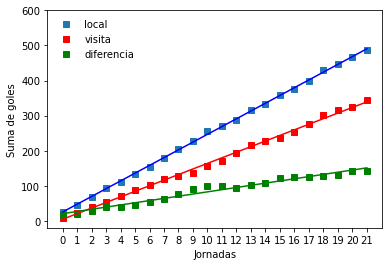

In [326]:
local_cumulativo=np.array(suma_goles_local_jornada)
visita_cumulativo=np.array(suma_goles_visita_jornada)
x=np.cumsum(local_cumulativo)
y=np.cumsum(visita_cumulativo)
z=np.cumsum(local_cumulativo-visita_cumulativo)
X=np.linspace(0, jornadascompletas, num=jornadascompletas).reshape((-1, 1))

plt.plot(x,'s',label='local')
plt.plot(y,'rs',label='visita')
plt.plot(z,'gs',label='diferencia')

model = LinearRegression()
model.fit(X, x)
model = LinearRegression().fit(X, x)
y_pred = model.predict(X)
r_sq = model.score(X, x)
print('Regresión lineal de sumatoria de goles de locales')
print(f"R^2: {r_sq}")
print(f"b: {model.intercept_}")
print(f"m: {model.coef_}")
plt.plot(y_pred,'-b')

model = LinearRegression()
model.fit(X, y)
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)
r_sq = model.score(X, y)
print('\nRegresión lineal de sumatoria de goles de visitantes')
print(f"R^2: {r_sq}")
print(f"b: {model.intercept_}")
print(f"m: {model.coef_}")
plt.plot(y_pred,'-r')

model = LinearRegression()
model.fit(X, z)
model = LinearRegression().fit(X, z)
y_pred = model.predict(X)
r_sq = model.score(X, z)
print('\nRegresión lineal de diferencia de goles por jornada')
print(f"R^2: {r_sq}")
print(f"b: {model.intercept_}")
print(f"m: {model.coef_}")
plt.plot(y_pred,'-g')

plt.legend(loc='upper left', prop={'size': 10}, frameon=False)
plt.xlabel('Jornadas')
plt.ylabel('Suma de goles')
plt.xticks(list(range(0,22)))
plt.yticks([0,100,200,300,400,500,600])

plt.savefig('mls_cumulativo_j{}.png'.format(jornadascompletas))
plt.show()

In [ ]:
resultado